In [1]:
import itertools
import os
from keras_segmentation.models.model_utils import get_segmentation_model, resize_image
from keras_segmentation.models.pspnet import get_segmentation_model
import tensorflow as tf
import random
import six
import numpy as np
import cv2
from tqdm import tqdm



from keras.models import *
from keras.layers import *
import keras.backend as K
from keras import layers

In [2]:
#构建模型
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    if 'channels_last' == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format='channels_last',
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format='channels_last',
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format='channels_last',
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x

def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format='channels_last')(x)
    if 'channels_last' == 'channels_first':
        x = Lambda(lambda x: x[:, :, :-1, :-1])(x)
    elif 'channels_last' == 'channels_last':
        x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x

def conv_block(input_tensor, kernel_size, filters, stage, block,
               strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at
                     main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with
    strides=(2,2) and the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    if 'channels_last' == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format='channels_last', strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format='channels_last',
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format='channels_last',
               name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format='channels_last',
                      strides=strides, name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height=224,  input_width=224,
                         pretrained='imagenet',
                         include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=None,
                         pooling=None,
                         classes=1000, channels=3):

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if 'channels_last' == 'channels_first':
        img_input = Input(shape=(channels, input_height, input_width))
    elif 'channels_last' == 'channels_last':
        img_input = Input(shape=(input_height, input_width, channels))

    if 'channels_last' == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3), data_format='channels_last')(img_input)
    x = Conv2D(64, (7, 7), data_format='channels_last',
               strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format='channels_last', strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D(
        (7, 7), data_format='channels_last', name='avg_pool')(x)
    # f6 = x

    if pretrained == 'imagenet':
        pretrained_url = "https://github.com/fchollet/deep-learning-models/" \
                         "releases/download/v0.2/" \
                         "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
        weights_path = tf.keras.utils.get_file(
            pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(weights_path, by_name=True, skip_mismatch=True)

    return img_input, [f1, f2, f3, f4, f5]

def pool_block(feats, pool_factor):

    if 'channels_last' == 'channels_first':
        h = K.int_shape(feats)[2]
        w = K.int_shape(feats)[3]
    elif 'channels_last' == 'channels_last':
        h = K.int_shape(feats)[1]
        w = K.int_shape(feats)[2]

    pool_size = strides = [
        int(np.round(float(h) / pool_factor)),
        int(np.round(float(w) / pool_factor))]

    x = AveragePooling2D(pool_size, data_format='channels_last',
                         strides=strides, padding='same')(feats)
    x = Conv2D(512, (1, 1), data_format='channels_last',
               padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = resize_image(x, strides, data_format='channels_last')

    return x

def _pspnet(n_classes, encoder,  input_height=384, input_width=576, channels=3):

    assert input_height % 192 == 0
    assert input_width % 192 == 0

    img_input, levels = encoder(
        input_height=input_height,  input_width=input_width, channels=channels)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    pool_factors = [1, 2, 3, 6]
    pool_outs = [o]

    for p in pool_factors:
        pooled = pool_block(o, p)
        pool_outs.append(pooled)

    o = Concatenate(axis=-1)(pool_outs)

    o = Conv2D(512, (1, 1), data_format='channels_last', use_bias=False , name="seg_feats" )(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    o = Conv2D(n_classes, (3, 3), data_format='channels_last',
               padding='same')(o)
    o = resize_image(o, (8, 8), data_format='channels_last')

    model = get_segmentation_model(img_input, o)
    return model

def resnet50_pspnet(n_classes,  input_height=384, input_width=576, channels=3):

    model = _pspnet(n_classes, get_resnet50_encoder,
                    input_height=input_height, input_width=input_width, channels=channels)
    model.model_name = "resnet50_pspnet"
    return model

In [3]:
input_height=384
input_width=576

random_color=[]
for i in range(5000):
    random_color.append((random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

train_images =  "leftImg8bit_trainvaltest/leftImg8bit/train/"
train_annotations = "gtFine_trainvaltest/gtFine/train/"

model = resnet50_pspnet(n_classes=34 ,  input_height=input_height, input_width=input_width)

In [4]:

def get_image_path(images_path, segs_path):
    img_paths = {}
    seg_paths = {}

    for dir_entry in os.listdir(images_path):
        dirname=os.path.join(images_path, dir_entry)
        for name in os.listdir(dirname):
            if '_leftImg8bit' in name:
                img_paths[name.replace('_leftImg8bit','')]=os.path.join(dirname, name)

    for dir_entry in os.listdir(segs_path):
        dirname=os.path.join(segs_path, dir_entry)
        for name in os.listdir(dirname):
            if '_gtFine_labelIds' in name:
                seg_paths[name.replace('_gtFine_labelIds','')]=os.path.join(dirname, name)

    lst_image_paths = []
    for name in img_paths:
        if name in seg_paths:
                lst_image_paths.append((img_paths[name],
                                     seg_paths[name]))

    return lst_image_paths


def resize_seg_img(seg_arr, inp_img=None, classes=None,
                           colors=random_color):

    if classes is None:
        classes = np.max(seg_arr)

    seg_img = segimg_color(seg_arr, classes, colors=colors)

    if inp_img is not None:
        original_h = inp_img.shape[0]
        original_w = inp_img.shape[1]
        seg_img = cv2.resize(seg_img, (original_w, original_h), interpolation=cv2.INTER_NEAREST)

    return seg_img


def get_image_array(image_input,
                    width, height,
                    imgNorm="sub_mean", image_class=1):

    if type(image_input) is np.ndarray:
        img = image_input
    elif isinstance(image_input, six.string_types):
        img = cv2.imread(image_input, image_class)
    else:
        pass

    img = cv2.resize(img, (width, height))
    img = img.astype(np.float32)
    img = np.atleast_3d(img)

    means = [103.939, 116.779, 123.68]

    for i in range(min(img.shape[2], len(means))):
        img[:, :, i] -= means[i]
    img = img[:, :, ::-1]

    return img

In [5]:
def seg_img_to_arr(image_input, nClasses,
                           width, height, no_reshape=False, image_class=1):
    seg_labels = np.zeros((height, width, nClasses))

    if type(image_input) is np.ndarray:
        img = image_input
    else:
        img = cv2.imread(image_input, image_class)

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if not no_reshape:
        seg_labels = np.reshape(seg_labels, (width*height, nClasses))

    return seg_labels

In [6]:
def gen_img(images_path, segs_path, batch_size,
                                 classes, input_height, input_width,
                                 output_height, output_width,
                                 image_class=cv2.IMREAD_COLOR):

    lst_path = get_image_path(images_path, segs_path)
    random.shuffle(lst_path)
    zipped = itertools.cycle(lst_path)

    while True:
        X = []
        Y = []
        for _ in range(batch_size):

            im, seg = next(zipped)
            seg = cv2.imread(seg, 1)

            im = cv2.imread(im, image_class)

            X.append(get_image_array(im, input_width,
                                     input_height))
            Y.append(seg_img_to_arr(
                seg, classes, output_width, output_height))
        yield np.array(X), np.array(Y)


def segimg_color(seg_arr, classes, colors=random_color):
    output_height = seg_arr.shape[0]
    output_width = seg_arr.shape[1]

    seg_img = np.zeros((output_height, output_width, 3))

    for c in range(classes):
        seg_arr_c = seg_arr[:, :] == c
        seg_img[:, :, 0] += ((seg_arr_c)*(colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((seg_arr_c)*(colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((seg_arr_c)*(colors[c][2])).astype('uint8')

    return seg_img

In [7]:
def predict(model=None, inp=None,
            out_fname=None,
            colors=random_color,
            image_class=1):


    if isinstance(inp, six.string_types):
        inp = cv2.imread(inp, image_class)

    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    classes = model.n_classes

    x = get_image_array(inp, input_width, input_height)
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height,  output_width, classes)).argmax(axis=2)

    seg_img = resize_seg_img(pr, inp, classes=classes,colors=colors)

    if out_fname is not None:
        cv2.imwrite(out_fname, seg_img)

    return pr

def evaluate(model=None, inp_images=None, annotations=None,
             inp_images_dir=None, annotations_dir=None, image_class=1):

    if inp_images is None:
        paths = get_image_path(inp_images_dir, annotations_dir)
        paths = list(zip(*paths))
        inp_images = list(paths[0])
        annotations = list(paths[1])

    tp = np.zeros(model.n_classes)
    fp = np.zeros(model.n_classes)
    fn = np.zeros(model.n_classes)
    tn = np.zeros(model.n_classes)
    n_pixels = np.zeros(model.n_classes)

    for inp, ann in tqdm(zip(inp_images, annotations)):
        pr = predict(model, inp, image_class=image_class)
        gt = seg_img_to_arr(ann, model.n_classes,
                                    model.output_width, model.output_height,
                                    no_reshape=True, image_class=image_class)
        gt = gt.argmax(-1)
        pr = pr.flatten()
        gt = gt.flatten()

        for cl_i in range(model.n_classes):

            tp[cl_i] += np.sum((pr == cl_i) * (gt == cl_i))
            fp[cl_i] += np.sum((pr == cl_i) * ((gt != cl_i)))
            fn[cl_i] += np.sum((pr != cl_i) * ((gt == cl_i)))

            tn[cl_i] += np.sum((pr != cl_i) * ((gt != cl_i)))
            n_pixels[cl_i] += np.sum(gt == cl_i)

    iou = tp / (tp + fp + fn+0.0000001)
    pa = (tp+tn) / (tp + fp + fn + tn)

    mean_IU = np.mean(iou)
    mean_pa = np.mean(pa)

    return {
        "iou": mean_IU,
        "PA": mean_pa,
    }


In [8]:
batch_size=1
step_n=256
image_class=1
classes = 34
output_height = model.output_height
output_width = model.output_width

In [9]:
model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

#数据生成器
train_gen = gen_img(
    train_images, train_annotations,  batch_size,  classes,
    input_height, input_width, output_height, output_width,
    image_class=image_class)

#训练模型
fit=model.fit(train_gen,
          epochs=20,
            steps_per_epoch=step_n,
          initial_epoch=0)

Epoch 1/20
256/256 [==============================] - 31s 75ms/step - loss: 1.1865 - accuracy: 0.6730
Epoch 2/20
256/256 [==============================] - 19s 76ms/step - loss: 1.1679 - accuracy: 0.6783
Epoch 3/20
256/256 [==============================] - 20s 77ms/step - loss: 0.9742 - accuracy: 0.7249
Epoch 4/20
256/256 [==============================] - 20s 79ms/step - loss: 0.9006 - accuracy: 0.7457
Epoch 5/20
256/256 [==============================] - 20s 80ms/step - loss: 0.8398 - accuracy: 0.7626
Epoch 6/20
256/256 [==============================] - 22s 85ms/step - loss: 0.8212 - accuracy: 0.7701
Epoch 7/20
256/256 [==============================] - 21s 83ms/step - loss: 0.9153 - accuracy: 0.7408
Epoch 8/20
256/256 [==============================] - 21s 83ms/step - loss: 0.9413 - accuracy: 0.7238
Epoch 9/20
256/256 [==============================] - 21s 82ms/step - loss: 0.8355 - accuracy: 0.7555
Epoch 10/20
256/256 [==============================] - 21s 83ms/step - loss: 0.830

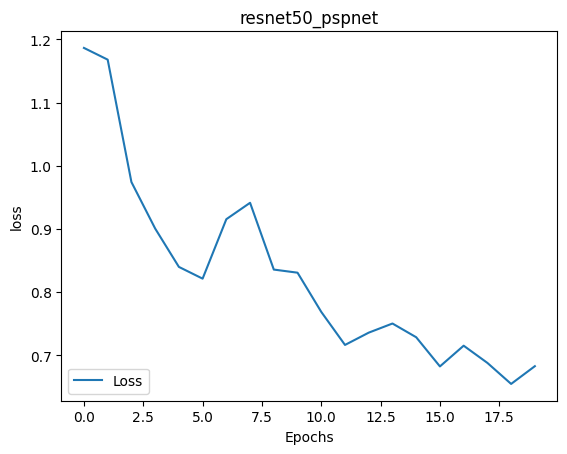

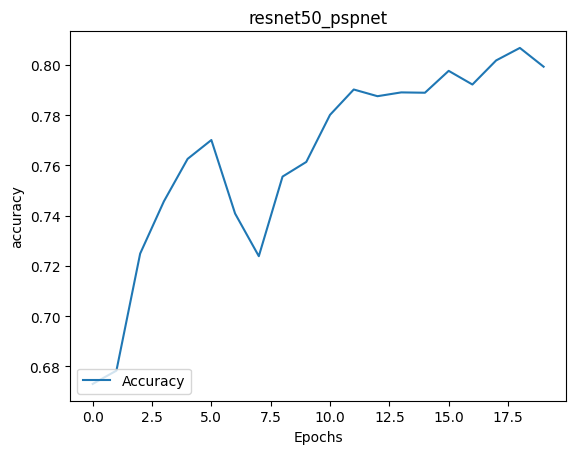

In [12]:
import matplotlib.pyplot as plt
#保存模型训练过程
plt.figure(1)
plt.plot(fit.history["loss"], label="Loss")
plt.title("resnet50_pspnet")
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.legend(loc="lower left")
plt.savefig("loss")

plt.figure(2)
plt.plot(fit.history["accuracy"], label="Accuracy")
plt.title("resnet50_pspnet")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.legend(loc="lower left")
plt.savefig("accuracy")
plt.show()

In [11]:
#评估模型
test_images =  "leftImg8bit_trainvaltest/leftImg8bit/val/"
test_annotations = "gtFine_trainvaltest/gtFine/val/"
test_result=evaluate(model, inp_images_dir=test_images,annotations_dir=test_annotations)
print(test_result)


0it [00:00, ?it/s]

1/1 [==============================] - 2s 2s/step


1it [00:02,  2.62s/it]

1/1 [==============================] - 0s 36ms/step


2it [00:02,  1.22s/it]

1/1 [==============================] - 0s 34ms/step


3it [00:03,  1.29it/s]

1/1 [==============================] - 0s 34ms/step


4it [00:03,  1.77it/s]

1/1 [==============================] - 0s 34ms/step


5it [00:03,  2.23it/s]

1/1 [==============================] - 0s 36ms/step


6it [00:03,  2.64it/s]

1/1 [==============================] - 0s 33ms/step


7it [00:04,  3.00it/s]

1/1 [==============================] - 0s 36ms/step


8it [00:04,  3.30it/s]

1/1 [==============================] - 0s 31ms/step


9it [00:04,  3.54it/s]

1/1 [==============================] - 0s 33ms/step


10it [00:04,  3.68it/s]

1/1 [==============================] - 0s 34ms/step


11it [00:05,  3.83it/s]

1/1 [==============================] - 0s 31ms/step


12it [00:05,  3.98it/s]

1/1 [==============================] - 0s 31ms/step


13it [00:05,  4.08it/s]

1/1 [==============================] - 0s 32ms/step


14it [00:05,  4.16it/s]

1/1 [==============================] - 0s 31ms/step


15it [00:05,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


16it [00:06,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


17it [00:06,  4.24it/s]

1/1 [==============================] - 0s 33ms/step


18it [00:06,  3.86it/s]

1/1 [==============================] - 0s 31ms/step


19it [00:06,  4.27it/s]

1/1 [==============================] - 0s 32ms/step


20it [00:07,  4.60it/s]

1/1 [==============================] - 0s 34ms/step


21it [00:07,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


22it [00:07,  5.18it/s]

1/1 [==============================] - 0s 32ms/step


23it [00:07,  5.37it/s]

1/1 [==============================] - 0s 31ms/step


24it [00:07,  5.51it/s]

1/1 [==============================] - 0s 30ms/step


25it [00:07,  5.50it/s]

1/1 [==============================] - 0s 32ms/step


26it [00:08,  5.54it/s]

1/1 [==============================] - 0s 31ms/step


27it [00:08,  5.48it/s]

1/1 [==============================] - 0s 32ms/step


28it [00:08,  5.45it/s]

1/1 [==============================] - 0s 32ms/step


29it [00:08,  5.16it/s]

1/1 [==============================] - 0s 30ms/step


30it [00:08,  4.92it/s]

1/1 [==============================] - 0s 30ms/step


31it [00:09,  4.81it/s]

1/1 [==============================] - 0s 32ms/step


32it [00:09,  4.67it/s]

1/1 [==============================] - 0s 37ms/step


33it [00:09,  4.57it/s]

1/1 [==============================] - 0s 32ms/step


34it [00:09,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


35it [00:10,  4.52it/s]

1/1 [==============================] - 0s 32ms/step


36it [00:10,  4.52it/s]

1/1 [==============================] - 0s 29ms/step


37it [00:10,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


38it [00:10,  4.49it/s]

1/1 [==============================] - 0s 30ms/step


39it [00:10,  4.50it/s]

1/1 [==============================] - 0s 36ms/step


40it [00:11,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


41it [00:11,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


42it [00:11,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


43it [00:11,  4.41it/s]

1/1 [==============================] - 0s 29ms/step


44it [00:12,  4.41it/s]

1/1 [==============================] - 0s 34ms/step


45it [00:12,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


46it [00:12,  4.38it/s]

1/1 [==============================] - 0s 34ms/step


47it [00:12,  3.92it/s]

1/1 [==============================] - 0s 30ms/step


48it [00:13,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


49it [00:13,  4.29it/s]

1/1 [==============================] - 0s 28ms/step


50it [00:13,  4.40it/s]

1/1 [==============================] - 0s 29ms/step


51it [00:13,  4.50it/s]

1/1 [==============================] - 0s 28ms/step


52it [00:13,  4.58it/s]

1/1 [==============================] - 0s 32ms/step


53it [00:14,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


54it [00:14,  4.61it/s]

1/1 [==============================] - 0s 34ms/step


55it [00:14,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


56it [00:14,  4.37it/s]

1/1 [==============================] - 0s 31ms/step


57it [00:15,  3.92it/s]

1/1 [==============================] - 0s 32ms/step


58it [00:15,  4.25it/s]

1/1 [==============================] - 0s 33ms/step


59it [00:15,  4.52it/s]

1/1 [==============================] - 0s 31ms/step


60it [00:15,  4.74it/s]

1/1 [==============================] - 0s 35ms/step


61it [00:15,  4.97it/s]

1/1 [==============================] - 0s 30ms/step


62it [00:16,  5.14it/s]

1/1 [==============================] - 0s 31ms/step


63it [00:16,  5.24it/s]

1/1 [==============================] - 0s 30ms/step


64it [00:16,  5.47it/s]

1/1 [==============================] - 0s 34ms/step


65it [00:16,  5.57it/s]

1/1 [==============================] - 0s 30ms/step


66it [00:16,  5.67it/s]

1/1 [==============================] - 0s 29ms/step


67it [00:16,  5.76it/s]

1/1 [==============================] - 0s 32ms/step


68it [00:17,  5.37it/s]

1/1 [==============================] - 0s 32ms/step


69it [00:17,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


70it [00:17,  5.21it/s]

1/1 [==============================] - 0s 34ms/step


71it [00:17,  5.29it/s]

1/1 [==============================] - 0s 31ms/step


72it [00:17,  5.34it/s]

1/1 [==============================] - 0s 32ms/step


73it [00:18,  5.06it/s]

1/1 [==============================] - 0s 31ms/step


74it [00:18,  4.88it/s]

1/1 [==============================] - 0s 32ms/step


75it [00:18,  4.72it/s]

1/1 [==============================] - 0s 31ms/step


76it [00:18,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


77it [00:19,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


78it [00:19,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


79it [00:19,  4.45it/s]

1/1 [==============================] - 0s 34ms/step


80it [00:19,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


81it [00:19,  4.38it/s]

1/1 [==============================] - 0s 31ms/step


82it [00:20,  4.41it/s]

1/1 [==============================] - 0s 36ms/step


83it [00:20,  4.40it/s]

1/1 [==============================] - 0s 41ms/step


84it [00:20,  4.26it/s]

1/1 [==============================] - 0s 31ms/step


85it [00:20,  4.24it/s]

1/1 [==============================] - 0s 40ms/step


86it [00:21,  4.18it/s]

1/1 [==============================] - 0s 37ms/step


87it [00:21,  4.12it/s]

1/1 [==============================] - 0s 30ms/step


88it [00:21,  4.21it/s]

1/1 [==============================] - 0s 37ms/step


89it [00:21,  4.12it/s]

1/1 [==============================] - 0s 31ms/step


90it [00:22,  4.16it/s]

1/1 [==============================] - 0s 32ms/step


91it [00:22,  3.80it/s]

1/1 [==============================] - 0s 28ms/step


92it [00:22,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


93it [00:22,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


94it [00:22,  4.90it/s]

1/1 [==============================] - 0s 30ms/step


95it [00:23,  5.14it/s]

1/1 [==============================] - 0s 28ms/step


96it [00:23,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


97it [00:23,  5.44it/s]

1/1 [==============================] - 0s 30ms/step


98it [00:23,  5.41it/s]

1/1 [==============================] - 0s 31ms/step


99it [00:23,  5.48it/s]

1/1 [==============================] - 0s 30ms/step


100it [00:24,  5.52it/s]

1/1 [==============================] - 0s 31ms/step


101it [00:24,  5.56it/s]

1/1 [==============================] - 0s 29ms/step


102it [00:24,  5.26it/s]

1/1 [==============================] - 0s 35ms/step


103it [00:24,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


104it [00:24,  4.78it/s]

1/1 [==============================] - 0s 31ms/step


105it [00:25,  4.67it/s]

1/1 [==============================] - 0s 32ms/step


106it [00:25,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


107it [00:25,  4.55it/s]

1/1 [==============================] - 0s 34ms/step


108it [00:25,  4.47it/s]

1/1 [==============================] - 0s 35ms/step


109it [00:25,  4.40it/s]

1/1 [==============================] - 0s 31ms/step


110it [00:26,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


111it [00:26,  4.46it/s]

1/1 [==============================] - 0s 33ms/step


112it [00:26,  4.42it/s]

1/1 [==============================] - 0s 33ms/step


113it [00:26,  4.40it/s]

1/1 [==============================] - 0s 33ms/step


114it [00:27,  4.36it/s]

1/1 [==============================] - 0s 37ms/step


115it [00:27,  4.33it/s]

1/1 [==============================] - 0s 31ms/step


116it [00:27,  4.35it/s]

1/1 [==============================] - 0s 34ms/step


117it [00:27,  4.30it/s]

1/1 [==============================] - 0s 34ms/step


118it [00:28,  4.36it/s]

1/1 [==============================] - 0s 29ms/step


119it [00:28,  4.32it/s]

1/1 [==============================] - 0s 31ms/step


120it [00:28,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


121it [00:28,  4.30it/s]

1/1 [==============================] - 0s 30ms/step


122it [00:28,  4.71it/s]

1/1 [==============================] - 0s 31ms/step


123it [00:29,  4.91it/s]

1/1 [==============================] - 0s 30ms/step


124it [00:29,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


125it [00:29,  5.47it/s]

1/1 [==============================] - 0s 28ms/step


126it [00:29,  5.68it/s]

1/1 [==============================] - 0s 29ms/step


127it [00:29,  5.79it/s]

1/1 [==============================] - 0s 28ms/step


128it [00:29,  5.91it/s]

1/1 [==============================] - 0s 29ms/step


129it [00:30,  5.95it/s]

1/1 [==============================] - 0s 30ms/step


130it [00:30,  5.95it/s]

1/1 [==============================] - 0s 28ms/step


131it [00:30,  5.91it/s]

1/1 [==============================] - 0s 30ms/step


132it [00:30,  5.52it/s]

1/1 [==============================] - 0s 30ms/step


133it [00:30,  5.20it/s]

1/1 [==============================] - 0s 30ms/step


134it [00:31,  5.00it/s]

1/1 [==============================] - 0s 31ms/step


135it [00:31,  4.90it/s]

1/1 [==============================] - 0s 31ms/step


136it [00:31,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


137it [00:31,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


138it [00:31,  4.64it/s]

1/1 [==============================] - 0s 32ms/step


139it [00:32,  4.59it/s]

1/1 [==============================] - 0s 30ms/step


140it [00:32,  4.54it/s]

1/1 [==============================] - 0s 33ms/step


141it [00:32,  4.49it/s]

1/1 [==============================] - 0s 32ms/step


142it [00:32,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


143it [00:33,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


144it [00:33,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


145it [00:33,  4.45it/s]

1/1 [==============================] - 0s 30ms/step


146it [00:33,  4.44it/s]

1/1 [==============================] - 0s 31ms/step


147it [00:34,  4.45it/s]

1/1 [==============================] - 0s 31ms/step


148it [00:34,  4.49it/s]

1/1 [==============================] - 0s 31ms/step


149it [00:34,  4.50it/s]

1/1 [==============================] - 0s 31ms/step


150it [00:34,  4.49it/s]

1/1 [==============================] - 0s 37ms/step


151it [00:34,  4.42it/s]

1/1 [==============================] - 0s 34ms/step


152it [00:35,  3.87it/s]

1/1 [==============================] - 0s 30ms/step


153it [00:35,  4.24it/s]

1/1 [==============================] - 0s 32ms/step


154it [00:35,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


155it [00:35,  4.91it/s]

1/1 [==============================] - 0s 28ms/step


156it [00:35,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


157it [00:36,  5.36it/s]

1/1 [==============================] - 0s 29ms/step


158it [00:36,  5.54it/s]

1/1 [==============================] - 0s 29ms/step


159it [00:36,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


160it [00:36,  5.65it/s]

1/1 [==============================] - 0s 30ms/step


161it [00:36,  5.74it/s]

1/1 [==============================] - 0s 28ms/step


162it [00:36,  5.74it/s]

1/1 [==============================] - 0s 29ms/step


163it [00:37,  5.54it/s]

1/1 [==============================] - 0s 30ms/step


164it [00:37,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


165it [00:37,  5.05it/s]

1/1 [==============================] - 0s 28ms/step


166it [00:37,  4.94it/s]

1/1 [==============================] - 0s 30ms/step


167it [00:38,  4.84it/s]

1/1 [==============================] - 0s 30ms/step


168it [00:38,  4.73it/s]

1/1 [==============================] - 0s 29ms/step


169it [00:38,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


170it [00:38,  4.23it/s]

1/1 [==============================] - 0s 30ms/step


171it [00:38,  4.29it/s]

1/1 [==============================] - 0s 30ms/step


172it [00:39,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


173it [00:39,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


174it [00:39,  4.41it/s]

1/1 [==============================] - 0s 31ms/step


175it [00:39,  4.43it/s]

1/1 [==============================] - 0s 31ms/step


176it [00:40,  4.37it/s]

1/1 [==============================] - 0s 30ms/step


177it [00:40,  4.35it/s]

1/1 [==============================] - 0s 33ms/step


178it [00:40,  4.35it/s]

1/1 [==============================] - 0s 32ms/step


179it [00:40,  4.34it/s]

1/1 [==============================] - 0s 29ms/step


180it [00:41,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


181it [00:41,  4.32it/s]

1/1 [==============================] - 0s 27ms/step


182it [00:41,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


183it [00:41,  5.15it/s]

1/1 [==============================] - 0s 30ms/step


184it [00:41,  5.34it/s]

1/1 [==============================] - 0s 29ms/step


185it [00:41,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


186it [00:42,  5.65it/s]

1/1 [==============================] - 0s 30ms/step


187it [00:42,  5.63it/s]

1/1 [==============================] - 0s 31ms/step


188it [00:42,  5.75it/s]

1/1 [==============================] - 0s 30ms/step


189it [00:42,  5.86it/s]

1/1 [==============================] - 0s 28ms/step


190it [00:42,  5.83it/s]

1/1 [==============================] - 0s 29ms/step


191it [00:42,  5.77it/s]

1/1 [==============================] - 0s 28ms/step


192it [00:43,  5.67it/s]

1/1 [==============================] - 0s 28ms/step


193it [00:43,  5.64it/s]

1/1 [==============================] - 0s 32ms/step


194it [00:43,  5.60it/s]

1/1 [==============================] - 0s 29ms/step


195it [00:43,  5.48it/s]

1/1 [==============================] - 0s 29ms/step


196it [00:43,  5.49it/s]

1/1 [==============================] - 0s 29ms/step


197it [00:44,  5.49it/s]

1/1 [==============================] - 0s 28ms/step


198it [00:44,  5.50it/s]

1/1 [==============================] - 0s 30ms/step


199it [00:44,  5.42it/s]

1/1 [==============================] - 0s 32ms/step


200it [00:44,  5.03it/s]

1/1 [==============================] - 0s 31ms/step


201it [00:44,  4.86it/s]

1/1 [==============================] - 0s 30ms/step


202it [00:45,  4.76it/s]

1/1 [==============================] - 0s 31ms/step


203it [00:45,  4.69it/s]

1/1 [==============================] - 0s 34ms/step


204it [00:45,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


205it [00:45,  4.54it/s]

1/1 [==============================] - 0s 31ms/step


206it [00:46,  4.52it/s]

1/1 [==============================] - 0s 30ms/step


207it [00:46,  4.51it/s]

1/1 [==============================] - 0s 34ms/step


208it [00:46,  4.44it/s]

1/1 [==============================] - 0s 34ms/step


209it [00:46,  4.41it/s]

1/1 [==============================] - 0s 32ms/step


210it [00:46,  4.36it/s]

1/1 [==============================] - 0s 31ms/step


211it [00:47,  4.41it/s]

1/1 [==============================] - 0s 30ms/step


212it [00:47,  4.48it/s]

1/1 [==============================] - 0s 31ms/step


213it [00:47,  4.47it/s]

1/1 [==============================] - 0s 29ms/step


214it [00:47,  4.51it/s]

1/1 [==============================] - 0s 30ms/step


215it [00:48,  4.55it/s]

1/1 [==============================] - 0s 29ms/step


216it [00:48,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


217it [00:48,  4.63it/s]

1/1 [==============================] - 0s 29ms/step


218it [00:48,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


219it [00:48,  4.11it/s]

1/1 [==============================] - 0s 28ms/step


220it [00:49,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


221it [00:49,  4.98it/s]

1/1 [==============================] - 0s 27ms/step


222it [00:49,  5.35it/s]

1/1 [==============================] - 0s 28ms/step


223it [00:49,  5.56it/s]

1/1 [==============================] - 0s 31ms/step


224it [00:49,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


225it [00:49,  5.76it/s]

1/1 [==============================] - 0s 29ms/step


226it [00:50,  5.85it/s]

1/1 [==============================] - 0s 28ms/step


227it [00:50,  5.81it/s]

1/1 [==============================] - 0s 29ms/step


228it [00:50,  5.86it/s]

1/1 [==============================] - 0s 30ms/step


229it [00:50,  5.80it/s]

1/1 [==============================] - 0s 31ms/step


230it [00:50,  5.32it/s]

1/1 [==============================] - 0s 30ms/step


231it [00:51,  5.08it/s]

1/1 [==============================] - 0s 30ms/step


232it [00:51,  4.94it/s]

1/1 [==============================] - 0s 32ms/step


233it [00:51,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


234it [00:51,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


235it [00:51,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


236it [00:52,  4.69it/s]

1/1 [==============================] - 0s 28ms/step


237it [00:52,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


238it [00:52,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


239it [00:52,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


240it [00:53,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


241it [00:53,  4.58it/s]

1/1 [==============================] - 0s 30ms/step


242it [00:53,  4.53it/s]

1/1 [==============================] - 0s 29ms/step


243it [00:53,  4.54it/s]

1/1 [==============================] - 0s 30ms/step


244it [00:53,  4.56it/s]

1/1 [==============================] - 0s 30ms/step


245it [00:54,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


246it [00:54,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


247it [00:54,  4.60it/s]

1/1 [==============================] - 0s 28ms/step


248it [00:54,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


249it [00:55,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


250it [00:55,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


251it [00:55,  4.46it/s]

1/1 [==============================] - 0s 31ms/step


252it [00:55,  3.98it/s]

1/1 [==============================] - 0s 29ms/step


253it [00:55,  4.46it/s]

1/1 [==============================] - 0s 29ms/step


254it [00:56,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


255it [00:56,  5.14it/s]

1/1 [==============================] - 0s 26ms/step


256it [00:56,  5.36it/s]

1/1 [==============================] - 0s 27ms/step


257it [00:56,  5.53it/s]

1/1 [==============================] - 0s 29ms/step


258it [00:56,  5.61it/s]

1/1 [==============================] - 0s 28ms/step


259it [00:56,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


260it [00:57,  5.94it/s]

1/1 [==============================] - 0s 30ms/step


261it [00:57,  5.95it/s]

1/1 [==============================] - 0s 30ms/step


262it [00:57,  5.93it/s]

1/1 [==============================] - 0s 28ms/step


263it [00:57,  5.97it/s]

1/1 [==============================] - 0s 29ms/step


264it [00:57,  5.49it/s]

1/1 [==============================] - 0s 30ms/step


265it [00:58,  5.21it/s]

1/1 [==============================] - 0s 29ms/step


266it [00:58,  5.06it/s]

1/1 [==============================] - 0s 28ms/step


267it [00:58,  4.92it/s]

1/1 [==============================] - 0s 28ms/step


268it [00:58,  4.89it/s]

1/1 [==============================] - 0s 33ms/step


269it [00:58,  4.85it/s]

1/1 [==============================] - 0s 29ms/step


270it [00:59,  4.81it/s]

1/1 [==============================] - 0s 30ms/step


271it [00:59,  4.80it/s]

1/1 [==============================] - 0s 29ms/step


272it [00:59,  4.77it/s]

1/1 [==============================] - 0s 29ms/step


273it [00:59,  4.79it/s]

1/1 [==============================] - 0s 29ms/step


274it [00:59,  4.75it/s]

1/1 [==============================] - 0s 29ms/step


275it [01:00,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


276it [01:00,  4.74it/s]

1/1 [==============================] - 0s 28ms/step


277it [01:00,  4.70it/s]

1/1 [==============================] - 0s 29ms/step


278it [01:00,  4.72it/s]

1/1 [==============================] - 0s 29ms/step


279it [01:01,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


280it [01:01,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


281it [01:01,  4.65it/s]

1/1 [==============================] - 0s 28ms/step


282it [01:01,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


283it [01:01,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


284it [01:02,  4.69it/s]

1/1 [==============================] - 0s 30ms/step


285it [01:02,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


286it [01:02,  4.57it/s]

1/1 [==============================] - 0s 30ms/step


287it [01:02,  4.19it/s]

1/1 [==============================] - 0s 28ms/step


288it [01:02,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


289it [01:03,  4.86it/s]

1/1 [==============================] - 0s 28ms/step


290it [01:03,  5.15it/s]

1/1 [==============================] - 0s 29ms/step


291it [01:03,  5.38it/s]

1/1 [==============================] - 0s 29ms/step


292it [01:03,  5.55it/s]

1/1 [==============================] - 0s 32ms/step


293it [01:03,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


294it [01:04,  5.55it/s]

1/1 [==============================] - 0s 29ms/step


295it [01:04,  5.66it/s]

1/1 [==============================] - 0s 29ms/step


296it [01:04,  5.63it/s]

1/1 [==============================] - 0s 29ms/step


297it [01:04,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


298it [01:04,  5.31it/s]

1/1 [==============================] - 0s 31ms/step


299it [01:04,  5.07it/s]

1/1 [==============================] - 0s 31ms/step


300it [01:05,  4.86it/s]

1/1 [==============================] - 0s 34ms/step


301it [01:05,  4.74it/s]

1/1 [==============================] - 0s 31ms/step


302it [01:05,  4.65it/s]

1/1 [==============================] - 0s 29ms/step


303it [01:05,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


304it [01:06,  4.68it/s]

1/1 [==============================] - 0s 32ms/step


305it [01:06,  4.65it/s]

1/1 [==============================] - 0s 31ms/step


306it [01:06,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


307it [01:06,  4.56it/s]

1/1 [==============================] - 0s 27ms/step


308it [01:06,  4.54it/s]

1/1 [==============================] - 0s 32ms/step


309it [01:07,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


310it [01:07,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


311it [01:07,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


312it [01:07,  4.63it/s]

1/1 [==============================] - 0s 32ms/step


313it [01:08,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


314it [01:08,  4.57it/s]

1/1 [==============================] - 0s 28ms/step


315it [01:08,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


316it [01:08,  4.59it/s]

1/1 [==============================] - 0s 31ms/step


317it [01:08,  4.60it/s]

1/1 [==============================] - 0s 30ms/step


318it [01:09,  4.59it/s]

1/1 [==============================] - 0s 34ms/step


319it [01:09,  4.21it/s]

1/1 [==============================] - 0s 30ms/step


320it [01:09,  3.90it/s]

1/1 [==============================] - 0s 28ms/step


321it [01:09,  4.40it/s]

1/1 [==============================] - 0s 27ms/step


322it [01:10,  4.82it/s]

1/1 [==============================] - 0s 30ms/step


323it [01:10,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


324it [01:10,  5.40it/s]

1/1 [==============================] - 0s 31ms/step


325it [01:10,  5.50it/s]

1/1 [==============================] - 0s 29ms/step


326it [01:10,  5.72it/s]

1/1 [==============================] - 0s 29ms/step


327it [01:10,  5.85it/s]

1/1 [==============================] - 0s 36ms/step


328it [01:11,  5.85it/s]

1/1 [==============================] - 0s 31ms/step


329it [01:11,  5.84it/s]

1/1 [==============================] - 0s 27ms/step


330it [01:11,  6.00it/s]

1/1 [==============================] - 0s 33ms/step


331it [01:11,  6.08it/s]

1/1 [==============================] - 0s 31ms/step


332it [01:11,  5.58it/s]

1/1 [==============================] - 0s 31ms/step


333it [01:11,  5.31it/s]

1/1 [==============================] - 0s 29ms/step


334it [01:12,  5.12it/s]

1/1 [==============================] - 0s 29ms/step


335it [01:12,  5.06it/s]

1/1 [==============================] - 0s 30ms/step


336it [01:12,  5.01it/s]

1/1 [==============================] - 0s 30ms/step


337it [01:12,  4.93it/s]

1/1 [==============================] - 0s 30ms/step


338it [01:12,  4.88it/s]

1/1 [==============================] - 0s 34ms/step


339it [01:13,  4.72it/s]

1/1 [==============================] - 0s 33ms/step


340it [01:13,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


341it [01:13,  4.74it/s]

1/1 [==============================] - 0s 29ms/step


342it [01:13,  4.73it/s]

1/1 [==============================] - 0s 28ms/step


343it [01:14,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


344it [01:14,  4.67it/s]

1/1 [==============================] - 0s 30ms/step


345it [01:14,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


346it [01:14,  4.64it/s]

1/1 [==============================] - 0s 31ms/step


347it [01:14,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


348it [01:15,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


349it [01:15,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


350it [01:15,  4.68it/s]

1/1 [==============================] - 0s 31ms/step


351it [01:15,  4.66it/s]

1/1 [==============================] - 0s 31ms/step


352it [01:16,  4.35it/s]

1/1 [==============================] - 0s 31ms/step


353it [01:16,  4.46it/s]

1/1 [==============================] - 0s 30ms/step


354it [01:16,  4.51it/s]

1/1 [==============================] - 0s 31ms/step


355it [01:16,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


356it [01:16,  4.62it/s]

1/1 [==============================] - 0s 28ms/step


357it [01:17,  4.67it/s]

1/1 [==============================] - 0s 36ms/step


358it [01:17,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


359it [01:17,  4.59it/s]

1/1 [==============================] - 0s 33ms/step


360it [01:17,  4.53it/s]

1/1 [==============================] - 0s 33ms/step


361it [01:18,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


362it [01:18,  3.91it/s]

1/1 [==============================] - 0s 29ms/step


363it [01:18,  4.39it/s]

1/1 [==============================] - 0s 27ms/step


364it [01:18,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


365it [01:18,  5.16it/s]

1/1 [==============================] - 0s 29ms/step


366it [01:18,  5.44it/s]

1/1 [==============================] - 0s 30ms/step


367it [01:19,  5.68it/s]

1/1 [==============================] - 0s 28ms/step


368it [01:19,  5.80it/s]

1/1 [==============================] - 0s 31ms/step


369it [01:19,  5.94it/s]

1/1 [==============================] - 0s 28ms/step


370it [01:19,  6.06it/s]

1/1 [==============================] - 0s 28ms/step


371it [01:19,  6.13it/s]

1/1 [==============================] - 0s 29ms/step


372it [01:19,  6.23it/s]

1/1 [==============================] - 0s 28ms/step


373it [01:20,  6.16it/s]

1/1 [==============================] - 0s 31ms/step


374it [01:20,  5.64it/s]

1/1 [==============================] - 0s 30ms/step


375it [01:20,  5.37it/s]

1/1 [==============================] - 0s 30ms/step


376it [01:20,  5.19it/s]

1/1 [==============================] - 0s 29ms/step


377it [01:20,  5.10it/s]

1/1 [==============================] - 0s 29ms/step


378it [01:21,  4.96it/s]

1/1 [==============================] - 0s 35ms/step


379it [01:21,  4.79it/s]

1/1 [==============================] - 0s 30ms/step


380it [01:21,  4.80it/s]

1/1 [==============================] - 0s 30ms/step


381it [01:21,  4.77it/s]

1/1 [==============================] - 0s 34ms/step


382it [01:22,  4.66it/s]

1/1 [==============================] - 0s 30ms/step


383it [01:22,  4.67it/s]

1/1 [==============================] - 0s 28ms/step


384it [01:22,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


385it [01:22,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


386it [01:22,  4.69it/s]

1/1 [==============================] - 0s 31ms/step


387it [01:23,  4.72it/s]

1/1 [==============================] - 0s 30ms/step


388it [01:23,  4.77it/s]

1/1 [==============================] - 0s 31ms/step


389it [01:23,  4.76it/s]

1/1 [==============================] - 0s 32ms/step


390it [01:23,  4.78it/s]

1/1 [==============================] - 0s 29ms/step


391it [01:23,  4.76it/s]

1/1 [==============================] - 0s 35ms/step


392it [01:24,  4.70it/s]

1/1 [==============================] - 0s 28ms/step


393it [01:24,  4.66it/s]

1/1 [==============================] - 0s 33ms/step


394it [01:24,  4.67it/s]

1/1 [==============================] - 0s 33ms/step


395it [01:24,  4.61it/s]

1/1 [==============================] - 0s 28ms/step


396it [01:24,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


397it [01:25,  4.14it/s]

1/1 [==============================] - 0s 28ms/step


398it [01:25,  4.57it/s]

1/1 [==============================] - 0s 27ms/step


399it [01:25,  4.92it/s]

1/1 [==============================] - 0s 29ms/step


400it [01:25,  5.18it/s]

1/1 [==============================] - 0s 27ms/step


401it [01:25,  5.42it/s]

1/1 [==============================] - 0s 31ms/step


402it [01:26,  5.36it/s]

1/1 [==============================] - 0s 29ms/step


403it [01:26,  5.48it/s]

1/1 [==============================] - 0s 30ms/step


404it [01:26,  5.64it/s]

1/1 [==============================] - 0s 30ms/step


405it [01:26,  5.68it/s]

1/1 [==============================] - 0s 29ms/step


406it [01:26,  5.65it/s]

1/1 [==============================] - 0s 28ms/step


407it [01:27,  5.77it/s]

1/1 [==============================] - 0s 31ms/step


408it [01:27,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


409it [01:27,  5.77it/s]

1/1 [==============================] - 0s 29ms/step


410it [01:27,  5.43it/s]

1/1 [==============================] - 0s 28ms/step


411it [01:27,  5.00it/s]

1/1 [==============================] - 0s 29ms/step


412it [01:28,  4.90it/s]

1/1 [==============================] - 0s 34ms/step


413it [01:28,  4.75it/s]

1/1 [==============================] - 0s 31ms/step


414it [01:28,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


415it [01:28,  4.68it/s]

1/1 [==============================] - 0s 29ms/step


416it [01:28,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


417it [01:29,  4.70it/s]

1/1 [==============================] - 0s 30ms/step


418it [01:29,  4.66it/s]

1/1 [==============================] - 0s 28ms/step


419it [01:29,  4.64it/s]

1/1 [==============================] - 0s 30ms/step


420it [01:29,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


421it [01:29,  4.58it/s]

1/1 [==============================] - 0s 28ms/step


422it [01:30,  4.55it/s]

1/1 [==============================] - 0s 30ms/step


423it [01:30,  4.62it/s]

1/1 [==============================] - 0s 33ms/step


424it [01:30,  4.57it/s]

1/1 [==============================] - 0s 29ms/step


425it [01:30,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


426it [01:31,  4.62it/s]

1/1 [==============================] - 0s 30ms/step


427it [01:31,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


428it [01:31,  4.58it/s]

1/1 [==============================] - 0s 31ms/step


429it [01:31,  4.06it/s]

1/1 [==============================] - 0s 28ms/step


430it [01:31,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


431it [01:32,  4.94it/s]

1/1 [==============================] - 0s 28ms/step


432it [01:32,  5.23it/s]

1/1 [==============================] - 0s 28ms/step


433it [01:32,  5.51it/s]

1/1 [==============================] - 0s 31ms/step


434it [01:32,  5.67it/s]

1/1 [==============================] - 0s 27ms/step


435it [01:32,  5.84it/s]

1/1 [==============================] - 0s 29ms/step


436it [01:32,  5.85it/s]

1/1 [==============================] - 0s 28ms/step


437it [01:33,  5.99it/s]

1/1 [==============================] - 0s 31ms/step


438it [01:33,  6.03it/s]

1/1 [==============================] - 0s 28ms/step


439it [01:33,  6.01it/s]

1/1 [==============================] - 0s 28ms/step


440it [01:33,  6.07it/s]

1/1 [==============================] - 0s 29ms/step


441it [01:33,  5.59it/s]

1/1 [==============================] - 0s 29ms/step


442it [01:34,  5.34it/s]

1/1 [==============================] - 0s 32ms/step


443it [01:34,  5.15it/s]

1/1 [==============================] - 0s 35ms/step


444it [01:34,  4.92it/s]

1/1 [==============================] - 0s 31ms/step


445it [01:34,  4.87it/s]

1/1 [==============================] - 0s 29ms/step


446it [01:34,  4.83it/s]

1/1 [==============================] - 0s 28ms/step


447it [01:35,  4.62it/s]

1/1 [==============================] - 0s 32ms/step


448it [01:35,  4.60it/s]

1/1 [==============================] - 0s 32ms/step


449it [01:35,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


450it [01:35,  4.60it/s]

1/1 [==============================] - 0s 29ms/step


451it [01:35,  4.67it/s]

1/1 [==============================] - 0s 31ms/step


452it [01:36,  4.71it/s]

1/1 [==============================] - 0s 28ms/step


453it [01:36,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


454it [01:36,  4.75it/s]

1/1 [==============================] - 0s 30ms/step


455it [01:36,  4.71it/s]

1/1 [==============================] - 0s 29ms/step


456it [01:37,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


457it [01:37,  4.64it/s]

1/1 [==============================] - 0s 41ms/step


458it [01:37,  4.44it/s]

1/1 [==============================] - 0s 38ms/step


459it [01:37,  3.94it/s]

1/1 [==============================] - 0s 34ms/step


460it [01:38,  4.30it/s]

1/1 [==============================] - 0s 32ms/step


461it [01:38,  4.60it/s]

1/1 [==============================] - 0s 38ms/step


462it [01:38,  4.81it/s]

1/1 [==============================] - 0s 28ms/step


463it [01:38,  5.13it/s]

1/1 [==============================] - 0s 28ms/step


464it [01:38,  5.41it/s]

1/1 [==============================] - 0s 30ms/step


465it [01:38,  5.69it/s]

1/1 [==============================] - 0s 33ms/step


466it [01:39,  5.73it/s]

1/1 [==============================] - 0s 32ms/step


467it [01:39,  5.83it/s]

1/1 [==============================] - 0s 29ms/step


468it [01:39,  5.97it/s]

1/1 [==============================] - 0s 31ms/step


469it [01:39,  5.87it/s]

1/1 [==============================] - 0s 29ms/step


470it [01:39,  5.81it/s]

1/1 [==============================] - 0s 32ms/step


471it [01:39,  5.46it/s]

1/1 [==============================] - 0s 30ms/step


472it [01:40,  5.17it/s]

1/1 [==============================] - 0s 31ms/step


473it [01:40,  4.97it/s]

1/1 [==============================] - 0s 34ms/step


474it [01:40,  4.83it/s]

1/1 [==============================] - 0s 29ms/step


475it [01:40,  4.76it/s]

1/1 [==============================] - 0s 30ms/step


476it [01:41,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


477it [01:41,  4.68it/s]

1/1 [==============================] - 0s 30ms/step


478it [01:41,  4.66it/s]

1/1 [==============================] - 0s 29ms/step


479it [01:41,  4.70it/s]

1/1 [==============================] - 0s 34ms/step


480it [01:41,  4.62it/s]

1/1 [==============================] - 0s 29ms/step


481it [01:42,  4.61it/s]

1/1 [==============================] - 0s 31ms/step


482it [01:42,  4.63it/s]

1/1 [==============================] - 0s 31ms/step


483it [01:42,  4.59it/s]

1/1 [==============================] - 0s 29ms/step


484it [01:42,  4.65it/s]

1/1 [==============================] - 0s 32ms/step


485it [01:42,  4.63it/s]

1/1 [==============================] - 0s 30ms/step


486it [01:43,  4.65it/s]

1/1 [==============================] - 0s 30ms/step


487it [01:43,  4.70it/s]

1/1 [==============================] - 0s 31ms/step


488it [01:43,  4.67it/s]

1/1 [==============================] - 0s 29ms/step


489it [01:43,  4.16it/s]

1/1 [==============================] - 0s 29ms/step


490it [01:44,  4.61it/s]

1/1 [==============================] - 0s 29ms/step


491it [01:44,  5.01it/s]

1/1 [==============================] - 0s 28ms/step


492it [01:44,  5.38it/s]

1/1 [==============================] - 0s 29ms/step


493it [01:44,  5.62it/s]

1/1 [==============================] - 0s 27ms/step


494it [01:44,  5.78it/s]

1/1 [==============================] - 0s 28ms/step


495it [01:44,  5.97it/s]

1/1 [==============================] - 0s 27ms/step


496it [01:44,  6.09it/s]

1/1 [==============================] - 0s 26ms/step


497it [01:45,  6.14it/s]

1/1 [==============================] - 0s 29ms/step


498it [01:45,  6.01it/s]

1/1 [==============================] - 0s 34ms/step


499it [01:45,  5.98it/s]

1/1 [==============================] - 0s 30ms/step


500it [01:45,  4.73it/s]

{'iou': 1.0574108115468258e-05, 'PA': 0.9411976188044664}
